# Exercise 5: Create your own personal face recognition using SVM

In [150]:
pip install numpy opencv-python scikit-learn

## Import libraries

In [151]:
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score, classification_report

## Mount Google Drive

In [152]:
from google.colab import drive
drive.mount('/content/drive')

BASE_PATH = '/content/drive/My Drive/Images'
TRAIN_PATH = os.path.join(BASE_PATH, 'Train')
TEST_PATH = os.path.join(BASE_PATH, 'Test')

PERSON1 = 'Santos'
PERSON2 = 'Viñas'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. Display one raw image directly from your drive

1. Raw images:


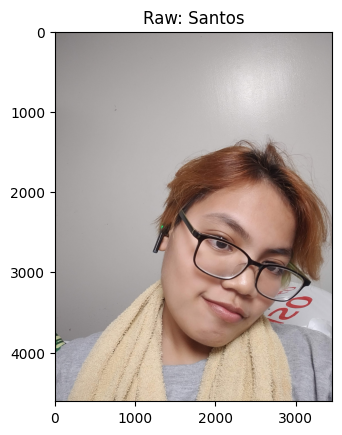

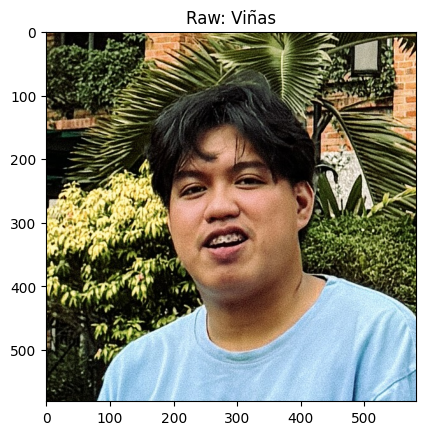

In [153]:
def displayImage(image_path, title=""):
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(title)
    plt.axis('on')
    plt.show()

print("1. Raw images:")

for person in [PERSON1, PERSON2]:
    folder = os.path.join(TRAIN_PATH, person)
    if os.path.exists(folder):
        files = [f for f in os.listdir(folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        if files:
            img_path = os.path.join(folder, files[0])
            displayImage(img_path, title=f"Raw: {person}")
        else:
            print(f" No images found in {folder}")
    else:
        print(f" Folder not found: {folder}")

## 2. Load the images from your drive and apply preprocessing to your raw images

In [154]:
def load_two_person_data(train_path, person1, person2):
    images = []
    labels = []

    for person in [person1, person2]:
        folder = os.path.join(train_path, person)
        if not os.path.isdir(folder):
            print(f"Folder missing: {folder}")
            continue
        print(f"Loading images from: {person}")
        for filename in os.listdir(folder):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(folder, filename)
                img = cv2.imread(img_path)
                if img is None:
                    continue
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                img = cv2.resize(img, (100, 100))
                images.append(img.flatten())
                labels.append(person)
    return np.array(images), np.array(labels)

images, labels = load_two_person_data(TRAIN_PATH, PERSON1, PERSON2)
print(f"\n2. Loaded {len(images)} images. Shape: {images.shape}")

if len(images) == 0:
    raise ValueError("No images loaded! Check the folder paths and image formats.")

Loading images from: Santos
Loading images from: Viñas

2. Loaded 180 images. Shape: (180, 10000)


## 3. Display one pre-processed image from the training set

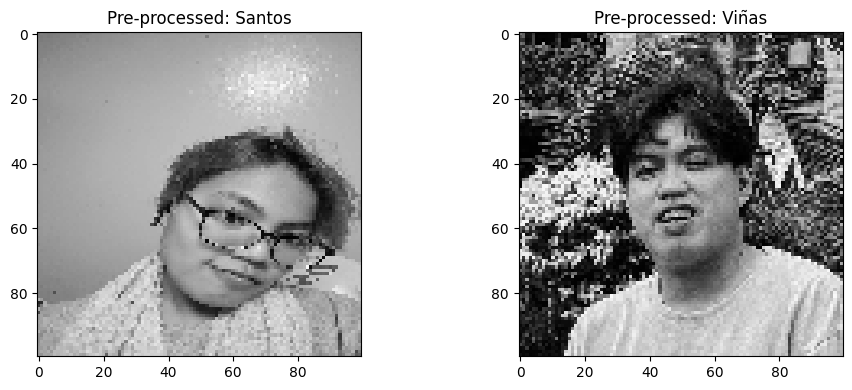

In [155]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
for i, person in enumerate([PERSON1, PERSON2]):
    indices = np.where(labels == person)[0]
    if len(indices) > 0:
        img = images[indices[0]].reshape(100, 100)
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f"Pre-processed: {person}")
        axes[i].axis('on')
    else:
        axes[i].text(0.5, 0.5, f"No image\nfor {person}", ha='center', va='center')
        axes[i].axis('off')

plt.tight_layout()
plt.show()

## 4. Display ten pre-processed images from the training set

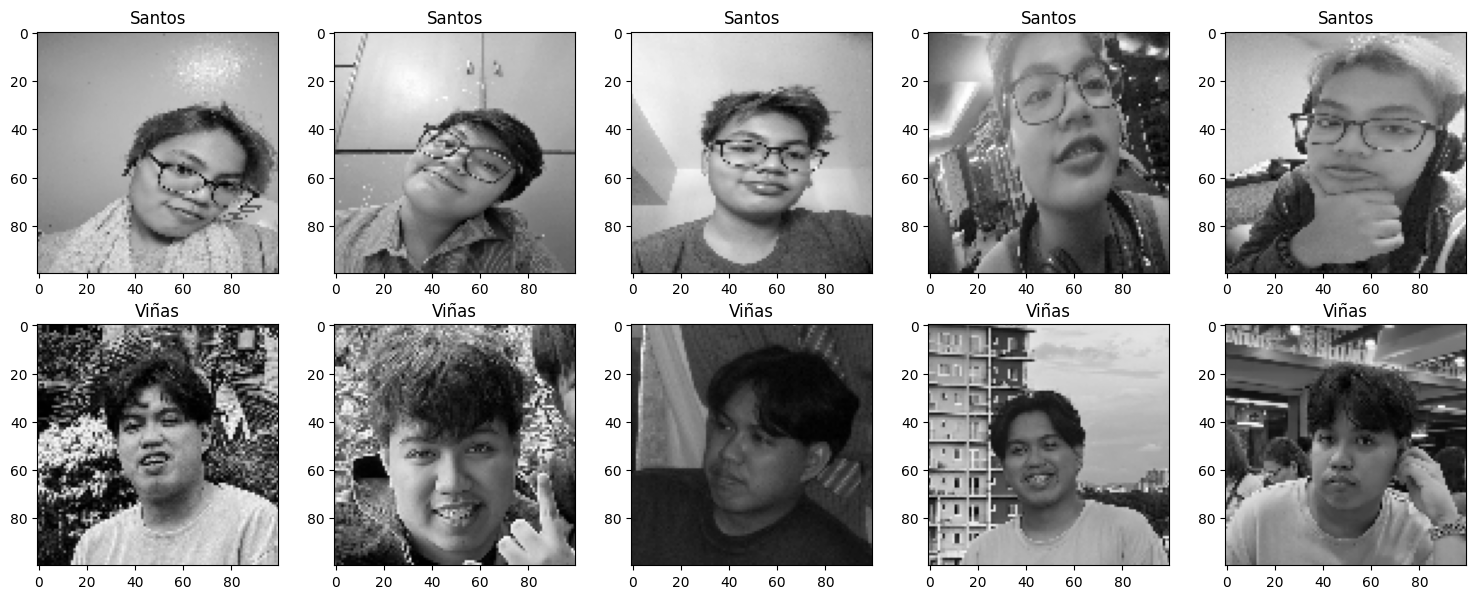

In [156]:
selected_images = []
selected_labels = []

for person in [PERSON1, PERSON2]:
    indices = np.where(labels == person)[0]
    selected_indices = indices[:5]
    for idx in selected_indices:
        selected_images.append(images[idx])
        selected_labels.append(labels[idx])

num_to_show = min(10, len(selected_images))
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for i in range(num_to_show):
    axes[i].imshow(selected_images[i].reshape(100, 100), cmap='gray')
    axes[i].set_title(selected_labels[i])
    axes[i].axis('on')

for j in range(num_to_show, 10):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

## 5. Split your training data

In [157]:
import pandas as pd

X_train, X_val, y_train, y_val = train_test_split(
    images, labels, test_size=0.2, random_state=42, stratify=labels
)
print(f"\n5. Data split:")
print(f"   Training: {X_train.shape[0]} ({np.bincount(pd.Categorical(y_train, categories=[PERSON1, PERSON2]).codes)})")
print(f"   Validation: {X_val.shape[0]} ({np.bincount(pd.Categorical(y_val, categories=[PERSON1, PERSON2]).codes)})")

from collections import Counter
print(f"   Train count: {Counter(y_train)}")
print(f"   Val count: {Counter(y_val)}")


5. Data split:
   Training: 144 ([72 72])
   Validation: 36 ([18 18])
   Train count: Counter({np.str_('Santos'): 72, np.str_('Viñas'): 72})
   Val count: Counter({np.str_('Santos'): 18, np.str_('Viñas'): 18})


## 6. Train your SVM model

In [158]:
model = svm.SVC(kernel='linear', random_state=42)
model.fit(X_train, y_train)
print("SVM training complete!")

SVM training complete!


## 7. Evaluate your SVM model

In [159]:
y_pred = model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print(f"\n7. Validation Accuracy: {accuracy * 100:.2f}%")
print("\nClassification Report:")
print(classification_report(y_val, y_pred, target_names=[PERSON1, PERSON2]))


7. Validation Accuracy: 86.11%

Classification Report:
              precision    recall  f1-score   support

      Santos       0.88      0.83      0.86        18
      Viñas       0.84      0.89      0.86        18

    accuracy                           0.86        36
   macro avg       0.86      0.86      0.86        36
weighted avg       0.86      0.86      0.86        36



## 8. Test your model using images not in your training set

Use your SVM model to predict the label of all of your images in the Test folder

Prediction for image 1: Santos


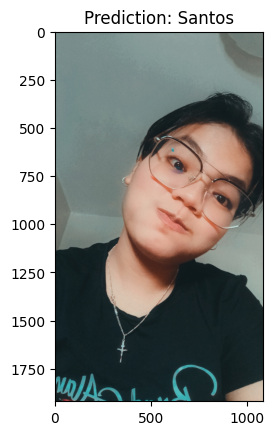

Prediction for image 2: Santos


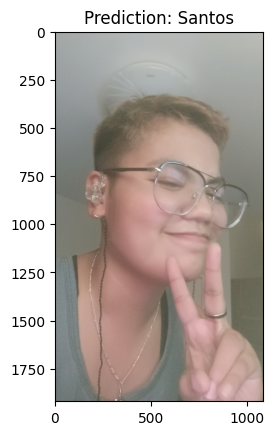

Prediction for image 3: Viñas


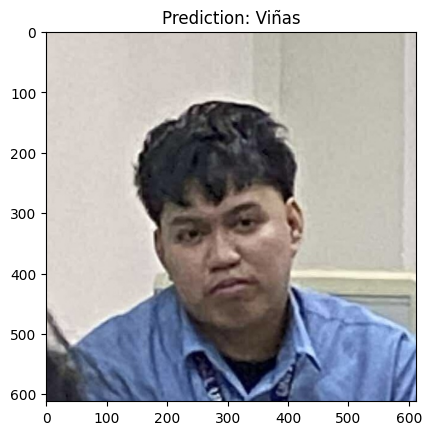

Prediction for image 4: Viñas


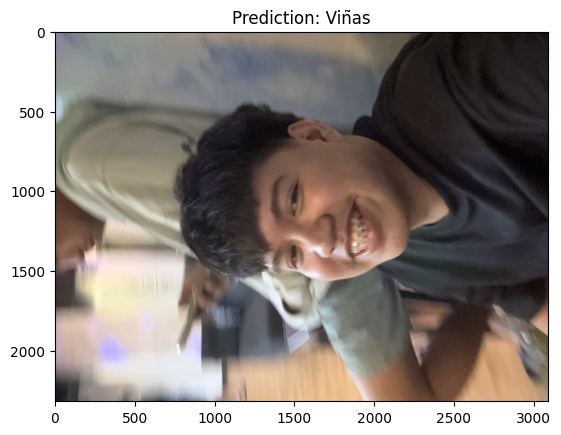

In [170]:
def predict_image(image_path, model):
    img = cv2.imread(image_path)
    if img is None:
        return "Error: Image not found or could not be read."
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (100, 100))
    img = img.flatten().reshape(1, -1)
    prediction = model.predict(img)
    return prediction[0]

img_path_1 = '/content/drive/My Drive/Images/Test/Santos/B612_20220611_091804_222.jpg'
img_path_2 = '/content/drive/My Drive/Images/Test/Santos/B612_20220714_223915_638.jpg'
img_path_3 = '/content/drive/My Drive/Images/Test/Viñas/9c81b081003a8971e205199249a418c9.jpeg'
img_path_4 = '/content/drive/My Drive/Images/Test/Viñas/IMG_0497.JPG'

result_1 = predict_image(img_path_1, model)
print(f'Prediction for image 1: {result_1}')
displayImage(img_path_1, title=f"Prediction: {result_1}")

result_2 = predict_image(img_path_2, model)
print(f'Prediction for image 2: {result_2}')
displayImage(img_path_2, title=f"Prediction: {result_2}")

result_3 = predict_image(img_path_3, model)
print(f'Prediction for image 3: {result_3}')
displayImage(img_path_3, title=f"Prediction: {result_3}")

result_4 = predict_image(img_path_4, model)
print(f'Prediction for image 4: {result_4}')
displayImage(img_path_4, title=f"Prediction: {result_4}")